In [1]:
import os
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
print(notebook_dir)
os.chdir(notebook_dir)

c:\Users\Blu\Desktop\GitHub\cmap\athirdmapper


['umbrella', 'fire extinguisher', 'a single traffic cone', 'luggage', 'pile of traffic cone', 'boxes', 'trash bin', 'sink', 'mirror']
[  0 100 101]


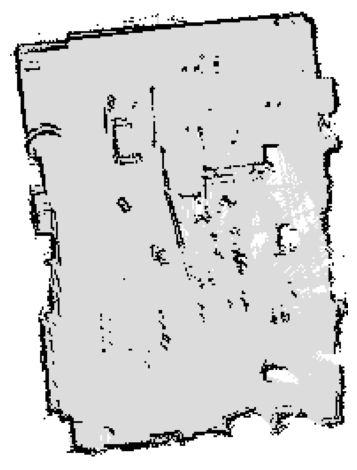

In [2]:
import cv2
import yaml
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
# os.chdir('/home/jetson/cmap/athirdmapper/exp01_0610')
os.chdir('./exp01_0610')
with open('features.pkl', 'rb') as file:
    features = pickle.load(file)
with open('features_ind.pkl', 'rb') as file:
    features_ind = pickle.load(file)
with open('text_features.pkl', 'rb') as file:
    text_features = pickle.load(file)
map_img = cv2.imread('map.pgm', cv2.IMREAD_GRAYSCALE)
with open('map.yaml', 'r') as file:
    map_data = yaml.safe_load(file)

print(text_features['list'])
print(np.unique(map_img))
_map = np.copy(map_img)
_map[_map == 101] = 255
_map[_map == 100] = 220
plt.imshow(np.flip(_map, 0), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()
# 101 = unknown space
# 0 = occupied space
# 100 = free space => 255

chair (175, 165, 125)
chair (175, 165, 125)


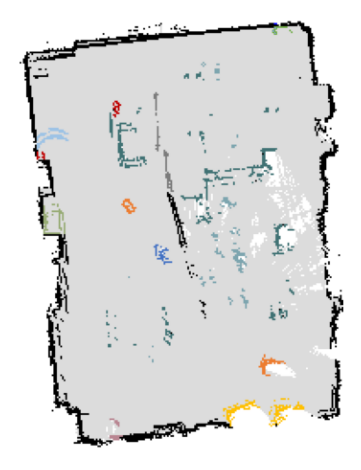

In [59]:
import cv2

# gt = np.copy(np.flip(_map, 0))
# gt = cv2.cvtColor(gt, cv2.COLOR_GRAY2BGR)
s = 5
# upscale the image
gt = cv2.resize(gt, (gt.shape[1]*s, gt.shape[0]*s), interpolation=cv2.INTER_NEAREST)
gt_ = np.copy(gt)
gtn = np.copy(gt)
_gt = np.copy(gt)
color = (0, 0, 255)
def draw_circle(event, x, y, flags, param):
    global color, s, gt_, gt
    x = x//(s*2)*(s*2)
    y = y//(s*2)*(s*2)
    if event == cv2.EVENT_LBUTTONDOWN:
        gt_ = np.copy(gt)
        for i in range(3*s):
            for j in range(3*s):
                if gt[y+i, x+j][0] == 0 and gt[y+i, x+j][1] == 0 and gt[y+i, x+j][2] == 0:
                    gt[y+i, x+j][0] = color[0]
                    gt[y+i, x+j][1] = color[1]
                    gt[y+i, x+j][2] = color[2]
        #cv2.rectangle(gt, (x, y), (x+(2*s), y+(2*s)), color, -1)
    if event == cv2.EVENT_RBUTTONDOWN:
        gt = np.copy(gt_)
cv2.namedWindow('Paint Image')
cv2.setMouseCallback('Paint Image', draw_circle)

legends = {
    'boxes': (0, 255, 0),
    'fire extinguisher': (0, 0, 255),
    'luggage': (255,0,0),
    'traffic cone': (0, 255, 255),
    'trash bin': (255, 255, 0),
    'umbrella': (255, 0, 255),
    'trolley': (128, 128, 0),
    'folded chair': (128, 0, 128),
}
n_legends = {
    'boxes': (0, 192, 255),
    'fire extinguisher': (0, 0, 192),
    'luggage': (196, 114, 68),
    'traffic cone': (49, 125, 237),
    'trash bin': (145, 133, 185),
    'umbrella': (230, 195, 157),
    'trolley': (117, 172, 152),
    'folded chair': (71,173,112),
    'white board': (124, 124, 124),
    'desk' : (116,114,64),
    'chair': (175, 165, 125)
}

while True:
    cv2.imshow('Paint Image', gt)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    if key == ord('w'):
        gt = np.copy(_gt)
    if key == ord('r'):
        gt = np.copy(gtn)
    if key == ord('c'):
        inst = input('Enter Instance:')
        try: color = n_legends[inst]
        except: color = (0, 0, 255)
        print(inst, color)
        _gt = np.copy(gt)
        continue
cv2.destroyAllWindows()
# downscale the image
gt = cv2.resize(gt, (gt.shape[1]//s, gt.shape[0]//s), interpolation=cv2.INTER_NEAREST)
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
plt.imshow(gt, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
import os
import pickle
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
def similarity(image_features, text_features):
    if isinstance(image_features, list): image_features = np.array(image_features)
    if isinstance(text_features, list): text_features = np.array(text_features)
    if torch.cuda.is_available(): 
        return image_features @ text_features.cpu().numpy().T
    return np.dot(image_features, text_features.T)
def show_images(ind, text='candidates'):
    for i, img_ind in enumerate(ind):
        r = len(ind)//7+1
        plt.figure(text, figsize=(9, r*2))
        plt.subplot(r, 7, i+1)
        img = cv2.imread('n_images/' + str(img_ind) + '.png')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.tight_layout()
    plt.show()
def point2pixel(point, origin, resolution):
    return (int((point[0] - origin[0]) / resolution),
            int((point[1] - origin[1]) / resolution))
def probmap(conf, map, map_data, grid_size, mode='freq'):
    d = 0 if mode == 'score' else 1
    origin = map_data['origin']
    resolution = map_data['resolution']
    max_p = max(conf.values(), key=lambda x: x[d])[d]
    min_p = min(conf.values(), key=lambda x: x[d])[d]
    grid_pixel = int(grid_size / resolution // 2)
    ret = np.copy(map)
    ret = cv2.cvtColor(ret, cv2.COLOR_GRAY2BGR)
    color = (0,0,255)
    for point, score in conf.items():
        x, y = point2pixel(point, origin, resolution)
        try: p = (score[d]-min_p) / (max_p-min_p)
        except ZeroDivisionError: p = 1
        layer = np.copy(ret)
        layer = cv2.rectangle(layer, (x-grid_pixel,y-grid_pixel), (x+grid_pixel,y+grid_pixel), color, -1)
        ret = cv2.addWeighted(ret, 1-p, layer, p, 0)
    return ret
def get_conf(features, voxels, text_feature, th=0.01, show_candidates=False, text='candidates'):
    similarities = similarity(features, text_feature).squeeze()*100
    softmax = F.softmax(torch.tensor(similarities), dim=0).numpy()
    m = np.sum(softmax > th)
    sim_sort_ind = np.argsort(similarities, axis=0)[::-1][:m]
    conf = {}
    for index in sim_sort_ind:
        # score = similarities[index]
        score = softmax[index]
        for point in features_ind[index]:
            [s, n] = conf.get(tuple(point), [0,0])
            conf[tuple(point)] = [(s * n + score) / (n + 1), n + 1]
    print(f'{m} frames detected')
    print(f'{len(conf)} grid points are detected')
    print('conf:', conf)
    if show_candidates: show_images(sim_sort_ind, text=text)
    # sort confidence by value
    # conf_score = dict(sorted(conf.items(), key=lambda item: item[1], reverse=True))
    # conf_freq = dict(sorted(conf.items(), key=lambda item: item[1][1], reverse=True))
    # k_s = list(conf_score.keys())
    # v_s = list(conf_score.values())
    # k_f = list(conf_freq.keys())
    # v_f = list(conf_freq.values())
    return conf

umbrella
33 frames detected
21 grid points are detected
conf: {(-5.5, -0.5, 0.0): [0.025109279675027595, 11], (-5.5, -0.25, 0.0): [0.02582516566155265, 10], (-5.25, -1.25, 0.0): [0.033949098200300745, 4], (-5.0, -1.25, 0.0): [0.027635832537487737, 11], (-5.0, -0.25, 0.0): [0.02204035219845319, 23], (-4.75, -0.25, 0.0): [0.022164420727136234, 26], (-4.5, -0.25, 0.0): [0.022929681595032884, 25], (-5.25, -0.5, 0.0): [0.021510682405793038, 17], (-5.25, -0.25, 0.0): [0.026094566545013735, 4], (-5.5, 0.0, 0.0): [0.01901967981370688, 5], (-5.0, -1.5, 0.0): [0.02535492371600465, 3], (-4.5, -0.5, 0.0): [0.017639062353179365, 10], (-4.25, -0.25, 0.0): [0.021419080811382503, 4], (-5.25, -0.75, 0.0): [0.017343399721613972, 4], (-5.0, -0.5, 0.0): [0.01657495607813039, 7], (-5.5, -0.75, 0.0): [0.016423226818062596, 2], (-5.0, -1.0, 0.0): [0.016677644171095716, 3], (-4.75, -1.5, 0.0): [0.01599332367262436, 1], (-4.75, -1.25, 0.0): [0.01599332367262436, 1], (-4.75, -0.5, 0.0): [0.01388271554914526, 3]

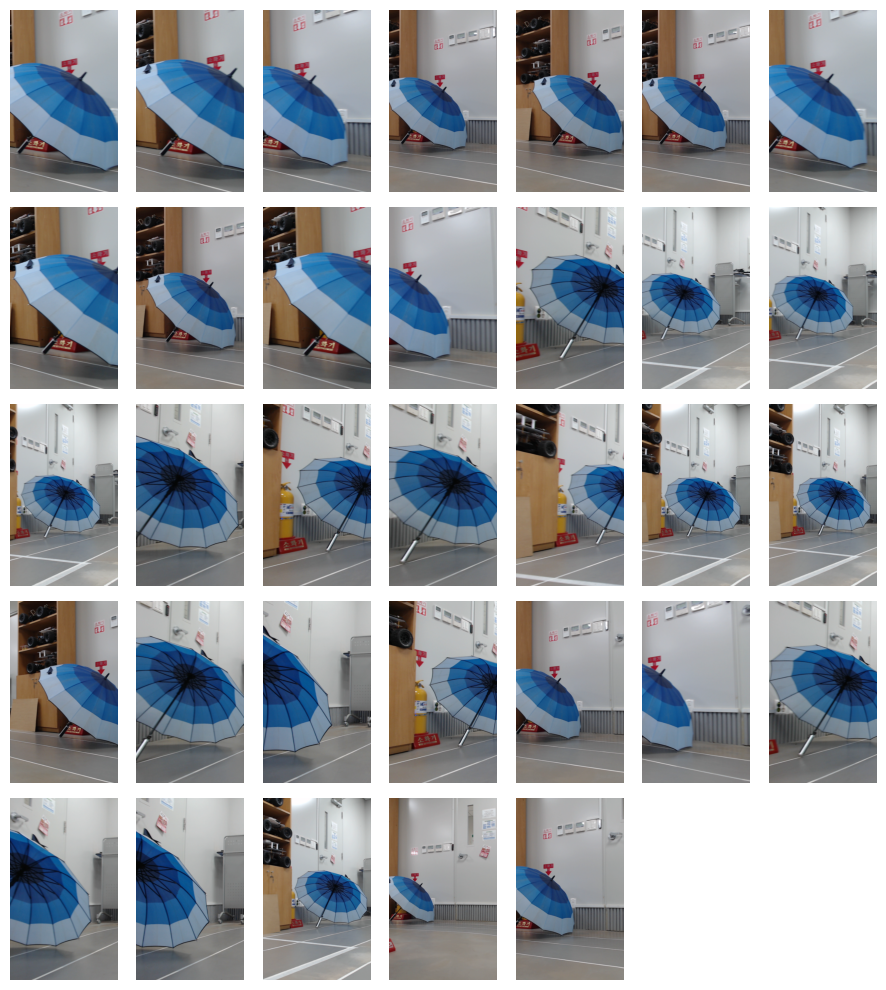

fire extinguisher
28 frames detected
16 grid points are detected
conf: {(-3.25, 0.0, 0.0): [0.035771478098504034, 18], (-3.25, 0.25, 0.0): [0.031460686826899724, 23], (-3.0, 0.5, 0.0): [0.03083766357429478, 26], (-3.0, 0.75, 0.0): [0.0350231458755131, 21], (-3.25, -0.25, 0.0): [0.03374279205180522, 8], (-3.0, -0.25, 0.0): [0.01913925196029387, 9], (-3.0, 0.0, 0.0): [0.020044194700618554, 8], (-3.0, 0.25, 0.0): [0.017117500211474214, 14], (-4.5, -0.25, 0.0): [0.026210990585699912, 6], (-4.75, -0.25, 0.0): [0.024213234408461584, 4], (-2.75, -0.25, 0.0): [0.0200737747634859, 2], (-2.75, 0.0, 0.0): [0.016204629920284357, 2], (-2.25, 0.5, 0.0): [0.014407613882854834, 4], (-1.75, 0.75, 0.0): [0.01564212654314884, 3], (-2.5, 0.5, 0.0): [0.01236747768113108, 1], (-1.75, 1.0, 0.0): [0.011728563924504049, 1]}


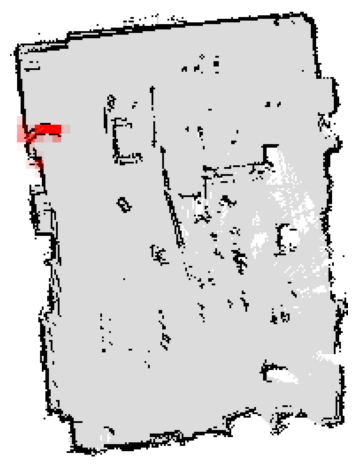

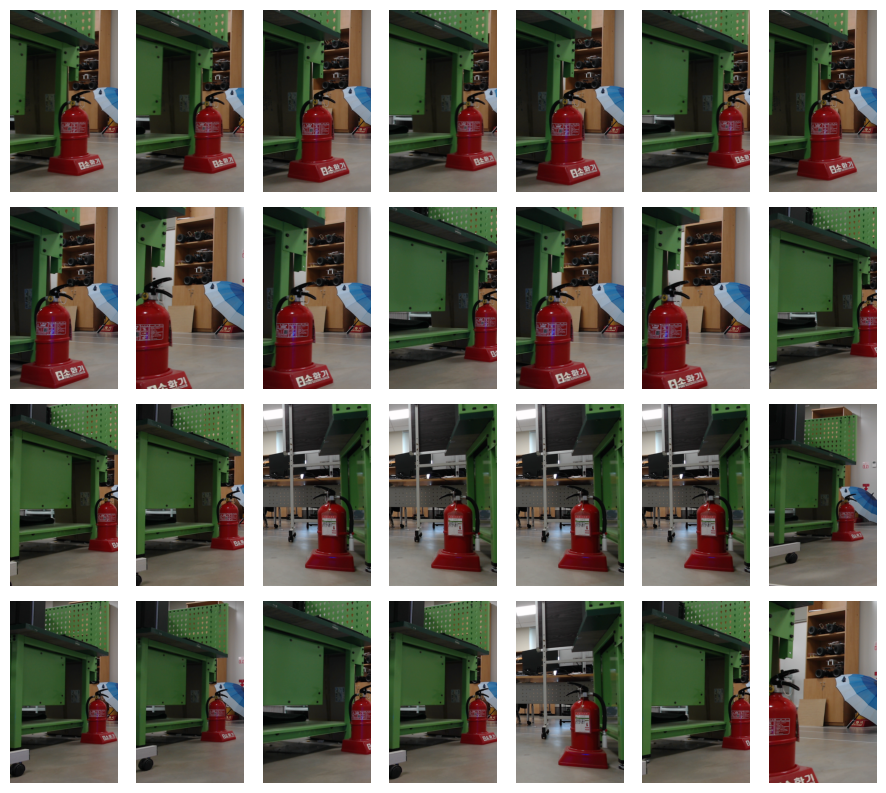

a single traffic cone
23 frames detected
10 grid points are detected
conf: {(-0.5, -5.5, 0.0): [0.055479366451332425, 5], (-2.75, -2.25, 0.0): [0.030183064337193376, 11], (1.25, -7.25, 0.0): [0.0287023121988987, 4], (1.25, -7.0, 0.0): [0.023749198415631945, 6], (1.5, -7.0, 0.0): [0.02267600800867421, 5], (-2.5, -2.25, 0.0): [0.014166050798259599, 6], (1.5, -7.25, 0.0): [0.013842970849098427, 2], (1.5, -6.75, 0.0): [0.013842970849098427, 2], (-2.75, -2.5, 0.0): [0.010280134680968634, 1], (-2.5, -2.5, 0.0): [0.010280134680968634, 1]}


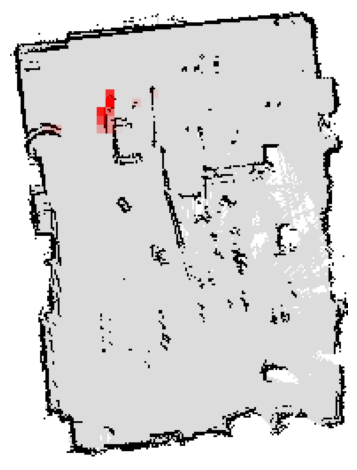

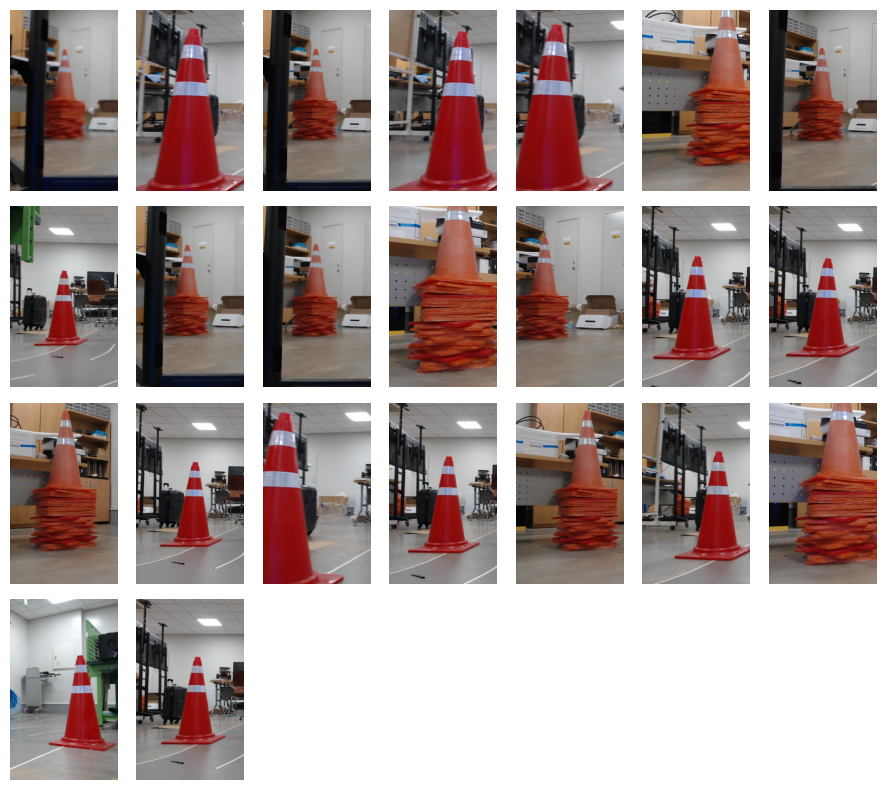

luggage
21 frames detected
6 grid points are detected
conf: {(-1.75, -3.75, 0.0): [0.02655749111451169, 6], (-1.75, -3.5, 0.0): [0.03283965678034458, 12], (-1.75, -4.0, 0.0): [0.016640415309553628, 2], (-1.5, -4.0, 0.0): [0.014302962973622822, 1], (-1.5, -6.0, 0.0): [0.011436561698536312, 1], (-1.5, -5.75, 0.0): [0.011436561698536312, 1]}


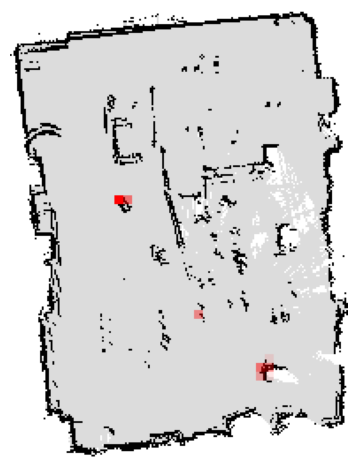

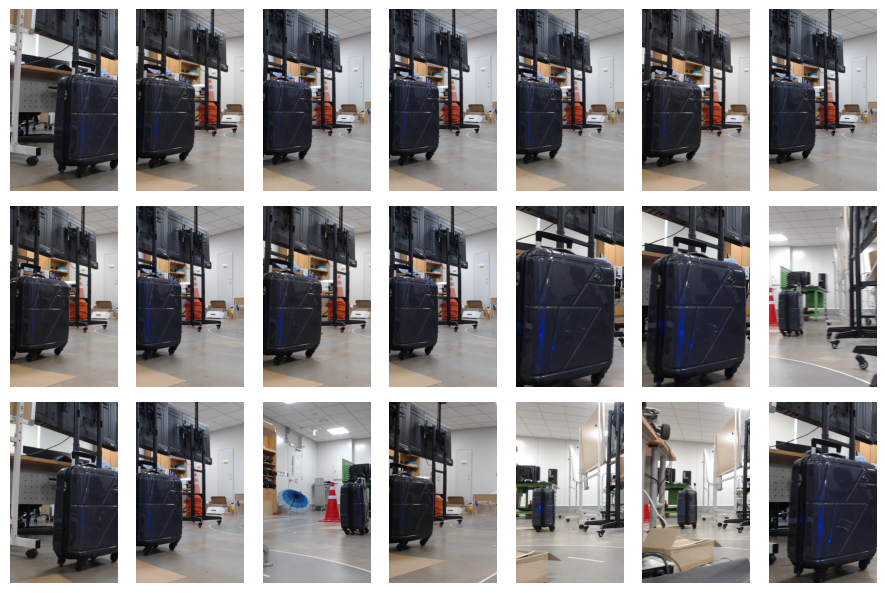

pile of traffic cone
21 frames detected
7 grid points are detected
conf: {(1.25, -7.25, 0.0): [0.06418933322390603, 11], (1.25, -7.0, 0.0): [0.0685812528229627, 10], (1.5, -7.0, 0.0): [0.07982390093911873, 8], (1.5, -7.5, 0.0): [0.023708362747028273, 3], (1.5, -7.25, 0.0): [0.023708362747028273, 3], (-0.5, -5.5, 0.0): [0.0215522204162612, 5], (-2.75, -2.25, 0.0): [0.032019885944182445, 1]}


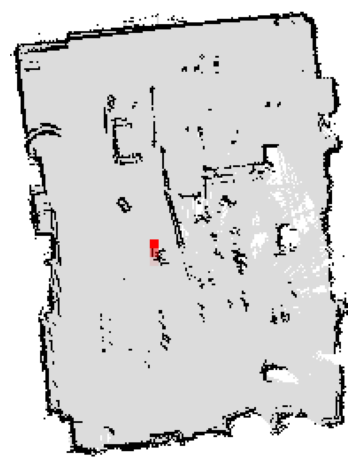

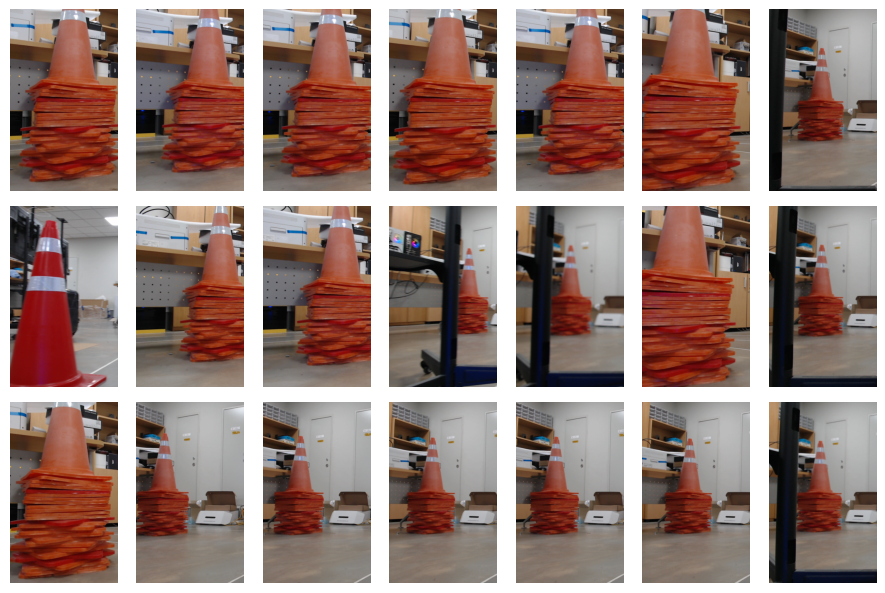

boxes
22 frames detected
31 grid points are detected
conf: {(0.75, -8.25, 0.0): [0.016935245898683317, 8], (1.0, -8.25, 0.0): [0.016142106466617994, 10], (1.5, -8.5, 0.0): [0.016030598385830156, 11], (1.75, -8.75, 0.0): [0.016619926587775464, 10], (1.75, -8.5, 0.0): [0.016030598385830156, 11], (-5.25, -1.25, 0.0): [0.032022533248523936, 1], (-5.25, -1.0, 0.0): [0.032022533248523936, 1], (-5.0, -1.75, 0.0): [0.032022533248523936, 1], (-5.0, -1.5, 0.0): [0.032022533248523936, 1], (-5.0, -1.25, 0.0): [0.032022533248523936, 1], (-5.0, -1.0, 0.0): [0.032022533248523936, 1], (-4.5, -0.25, 0.0): [0.032022533248523936, 1], (-0.25, -8.75, 0.0): [0.013745228535437318, 2], (0.0, -8.75, 0.0): [0.012585072091115382, 3], (0.25, -9.0, 0.0): [0.013745228535437318, 2], (0.25, -8.75, 0.0): [0.012585072091115382, 3], (0.25, -8.5, 0.0): [0.013745228535437318, 2], (1.75, -8.25, 0.0): [0.014344446584603137, 4], (2.0, -8.25, 0.0): [0.01357638809179309, 7], (2.0, -8.5, 0.0): [0.012917116617119175, 4], (2.25, 

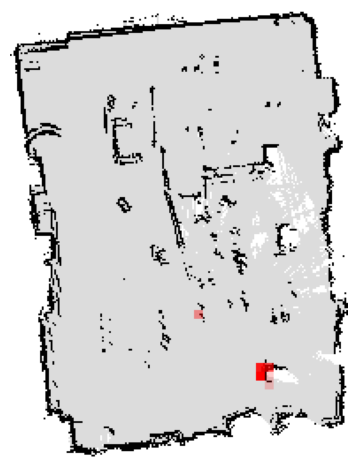

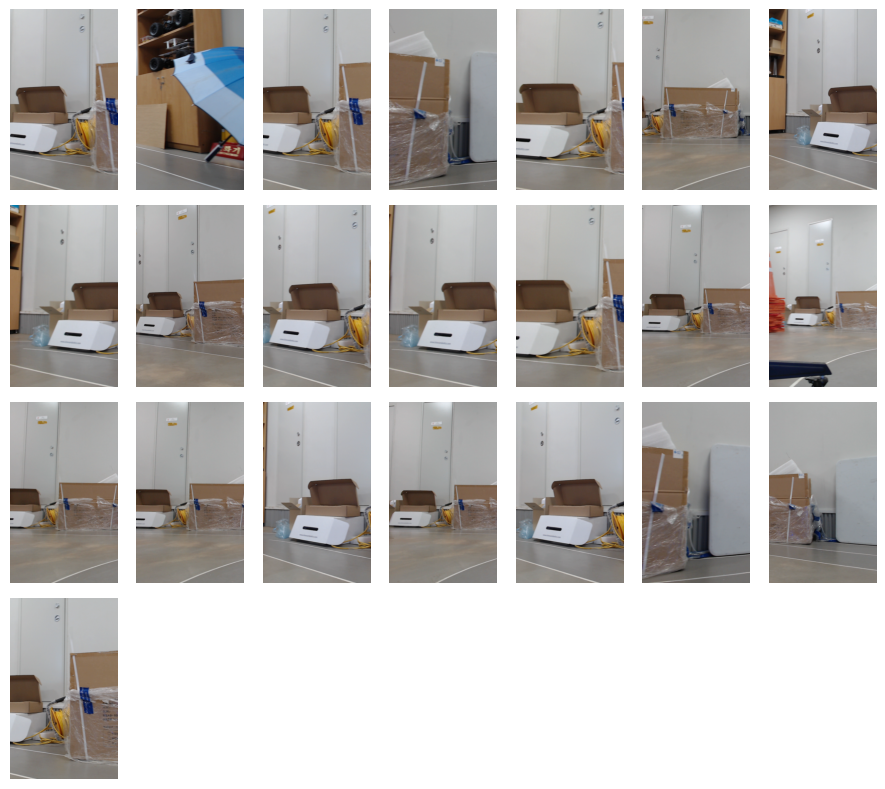

trash bin
24 frames detected
11 grid points are detected
conf: {(-3.25, -9.25, 0.0): [0.05140469680952439, 3], (-3.0, -9.25, 0.0): [0.05760973455034992, 2], (-3.0, -8.75, 0.0): [0.04389073319159429, 9], (-3.0, -9.0, 0.0): [0.08573379211853727, 1], (-2.5, -9.0, 0.0): [0.023788217950403878, 2], (-3.0, -8.5, 0.0): [0.021454303037854675, 1], (-2.75, -9.25, 0.0): [0.015402120157315824, 3], (-2.5, -9.25, 0.0): [0.016315332967587044, 3], (-2.25, -9.25, 0.0): [0.01852052715325558, 1], (-2.25, -9.0, 0.0): [0.018070810299547598, 1], (-2.0, -8.75, 0.0): [0.013135452583952028, 1]}


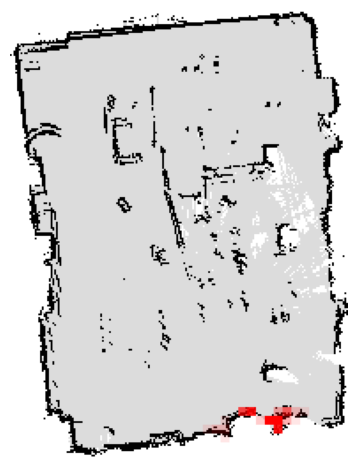

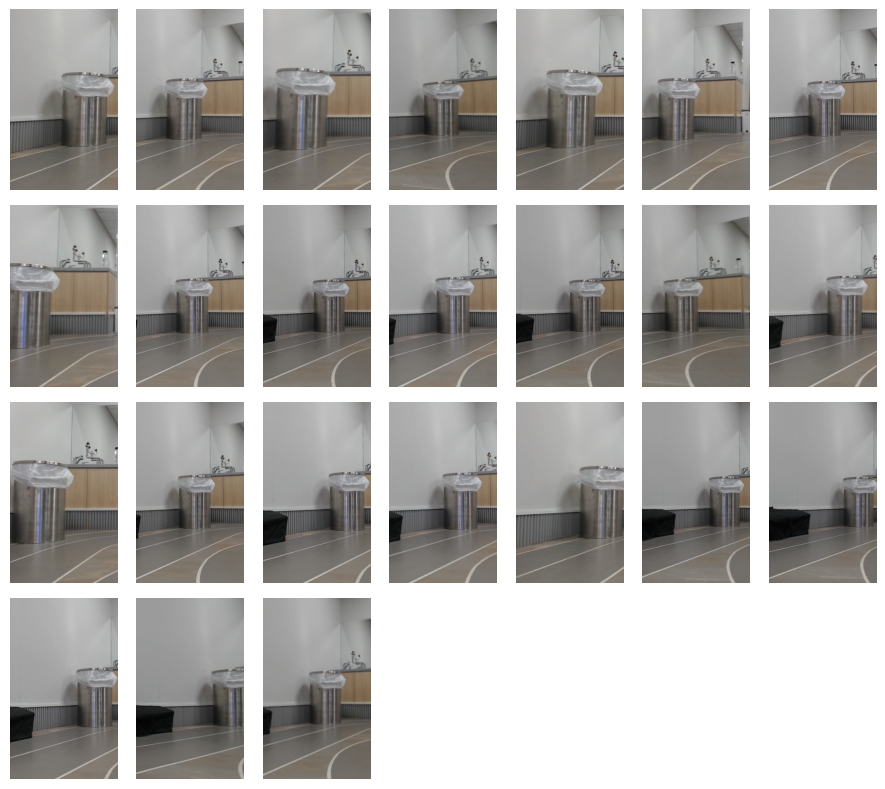

sink
12 frames detected
10 grid points are detected
conf: {(-5.25, 2.0, 0.0): [0.0570468148409104, 1], (-5.0, 2.0, 0.0): [0.0570468148409104, 1], (-4.75, 2.0, 0.0): [0.0570468148409104, 1], (-4.5, 2.0, 0.0): [0.0570468148409104, 1], (-4.25, 2.0, 0.0): [0.0570468148409104, 1], (-2.5, -9.25, 0.0): [0.01824667548601965, 1], (-2.5, -9.0, 0.0): [0.01797504493763737, 2], (-2.25, -9.0, 0.0): [0.01824667548601965, 1], (-3.0, -8.75, 0.0): [0.016013240268463184, 1], (-2.5, -4.75, 0.0): [0.013511508905012962, 1]}


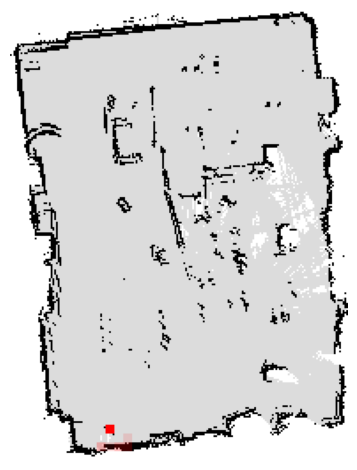

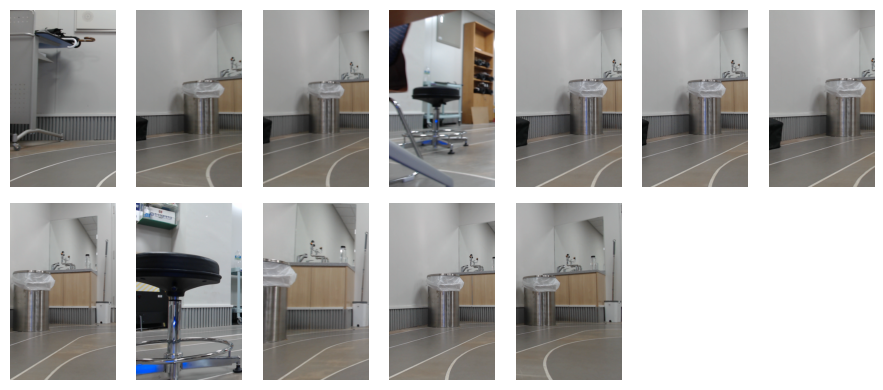

mirror
3 frames detected
15 grid points are detected
conf: {(-2.25, -1.0, 0.0): [0.011922631098639072, 1], (-1.5, -0.75, 0.0): [0.011922631098639072, 1], (-0.75, -0.25, 0.0): [0.011922631098639072, 1], (-0.5, -0.5, 0.0): [0.011922631098639072, 1], (-0.5, -0.25, 0.0): [0.011922631098639072, 1], (0.75, 2.75, 0.0): [0.01059840629378416, 1], (1.0, 2.75, 0.0): [0.010340367365079003, 2], (1.0, 3.0, 0.0): [0.01059840629378416, 1], (1.25, 3.0, 0.0): [0.010340367365079003, 2], (1.5, 2.75, 0.0): [0.01059840629378416, 1], (1.5, 3.0, 0.0): [0.010340367365079003, 2], (1.75, 2.75, 0.0): [0.01059840629378416, 1], (1.75, 3.0, 0.0): [0.010340367365079003, 2], (1.25, 2.75, 0.0): [0.010082328436373847, 1], (2.0, 3.0, 0.0): [0.010082328436373847, 1]}


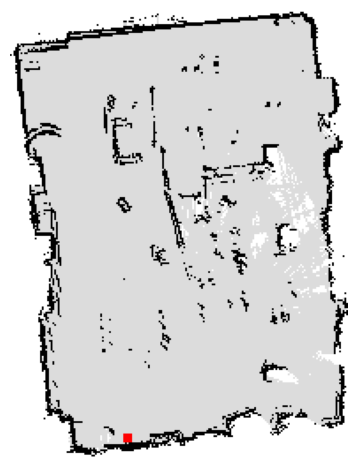

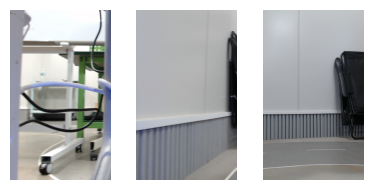

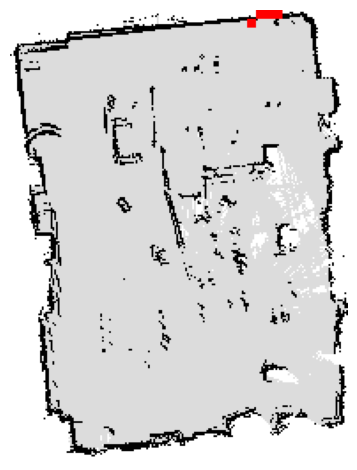

In [5]:
text_list = text_features['list']
for text in text_list:
    print(f'{text}')
    text_feature = text_features[text]
    conf = get_conf(features, features_ind, text_feature, show_candidates=True, text=text)
    probability_map = probmap(conf, _map, map_data, 0.25, 'freq')
    plt.figure(text)
    plt.axis('off')
    plt.tight_layout()
    probability_map = np.flip(probability_map, 0)
    probability_map = cv2.cvtColor(probability_map, cv2.COLOR_BGR2RGB)
    plt.imshow(probability_map)

In [6]:
os.chdir('../')
from utils import CLIP
os.chdir('../')
clip = CLIP('ViT-B-16-SigLIP')
os.chdir('./athirdmapper/exp01_0610')

c:\Users\Blu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Blu\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [7]:
from IPython.display import clear_output
while True:
    try:
        clear_output(wait=True)
        string = input('Enter text: ')
        if string == '': break
        print(f'{string}')
        text_feature = clip.encode_text([string])
        conf = get_conf(features, features_ind, text_feature, show_candidates=True, text=string)
        probability_map = probmap(conf, _map, map_data, 0.25, 'freq')
        plt.figure(string)
        plt.axis('off')
        plt.tight_layout()
        probability_map = np.flip(probability_map, 0)
        probability_map = cv2.cvtColor(probability_map, cv2.COLOR_BGR2RGB)
        plt.imshow(probability_map)
        plt.show()
    except Exception as e:
        print(e)